In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
#import seaborn as sns
import pickle
#import torch

import gc

import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [2]:
#local_dir = '/home/simon/Documents/Articles/ConflictNet/data/generated/'
#local_dir_raw = '/home/simon/Documents/Articles/ConflictNet/data/raw/'

local_dir = '/home/number_one/Documents/scripts/conflictNet/data/generated'
local_dir_raw = '/home/number_one/Documents/scripts/conflictNet/data/raw'
timelaps_dir = '/home/number_one/Documents/scripts/conflictNet/reports/timelapse/viewser_calib_sbnsos'
test_month = 48

with open(f'{local_dir}/posterior_dict_48_calib.pkl', 'rb') as file:
    posterior_dict = pickle.load(file)

with open(f'{local_dir}/test_vol_48_calib.pkl', 'rb') as file:
    test_vol = pickle.load(file)

with open(f'{local_dir_raw}/viewser_monthly_vol_calib.pkl', 'rb') as file:
    views_vol = pickle.load(file)



In [3]:
posterior_list = posterior_dict['posterior_list']
posterior_list_class = posterior_dict['posterior_list_class']
out_of_sample_vol = posterior_dict['out_of_sample_vol']

In [16]:
mean_class_pred = np.array(posterior_list_class[test_month]).mean(axis=0)
mean_pred = np.array(posterior_list[test_month]).mean(axis=0)

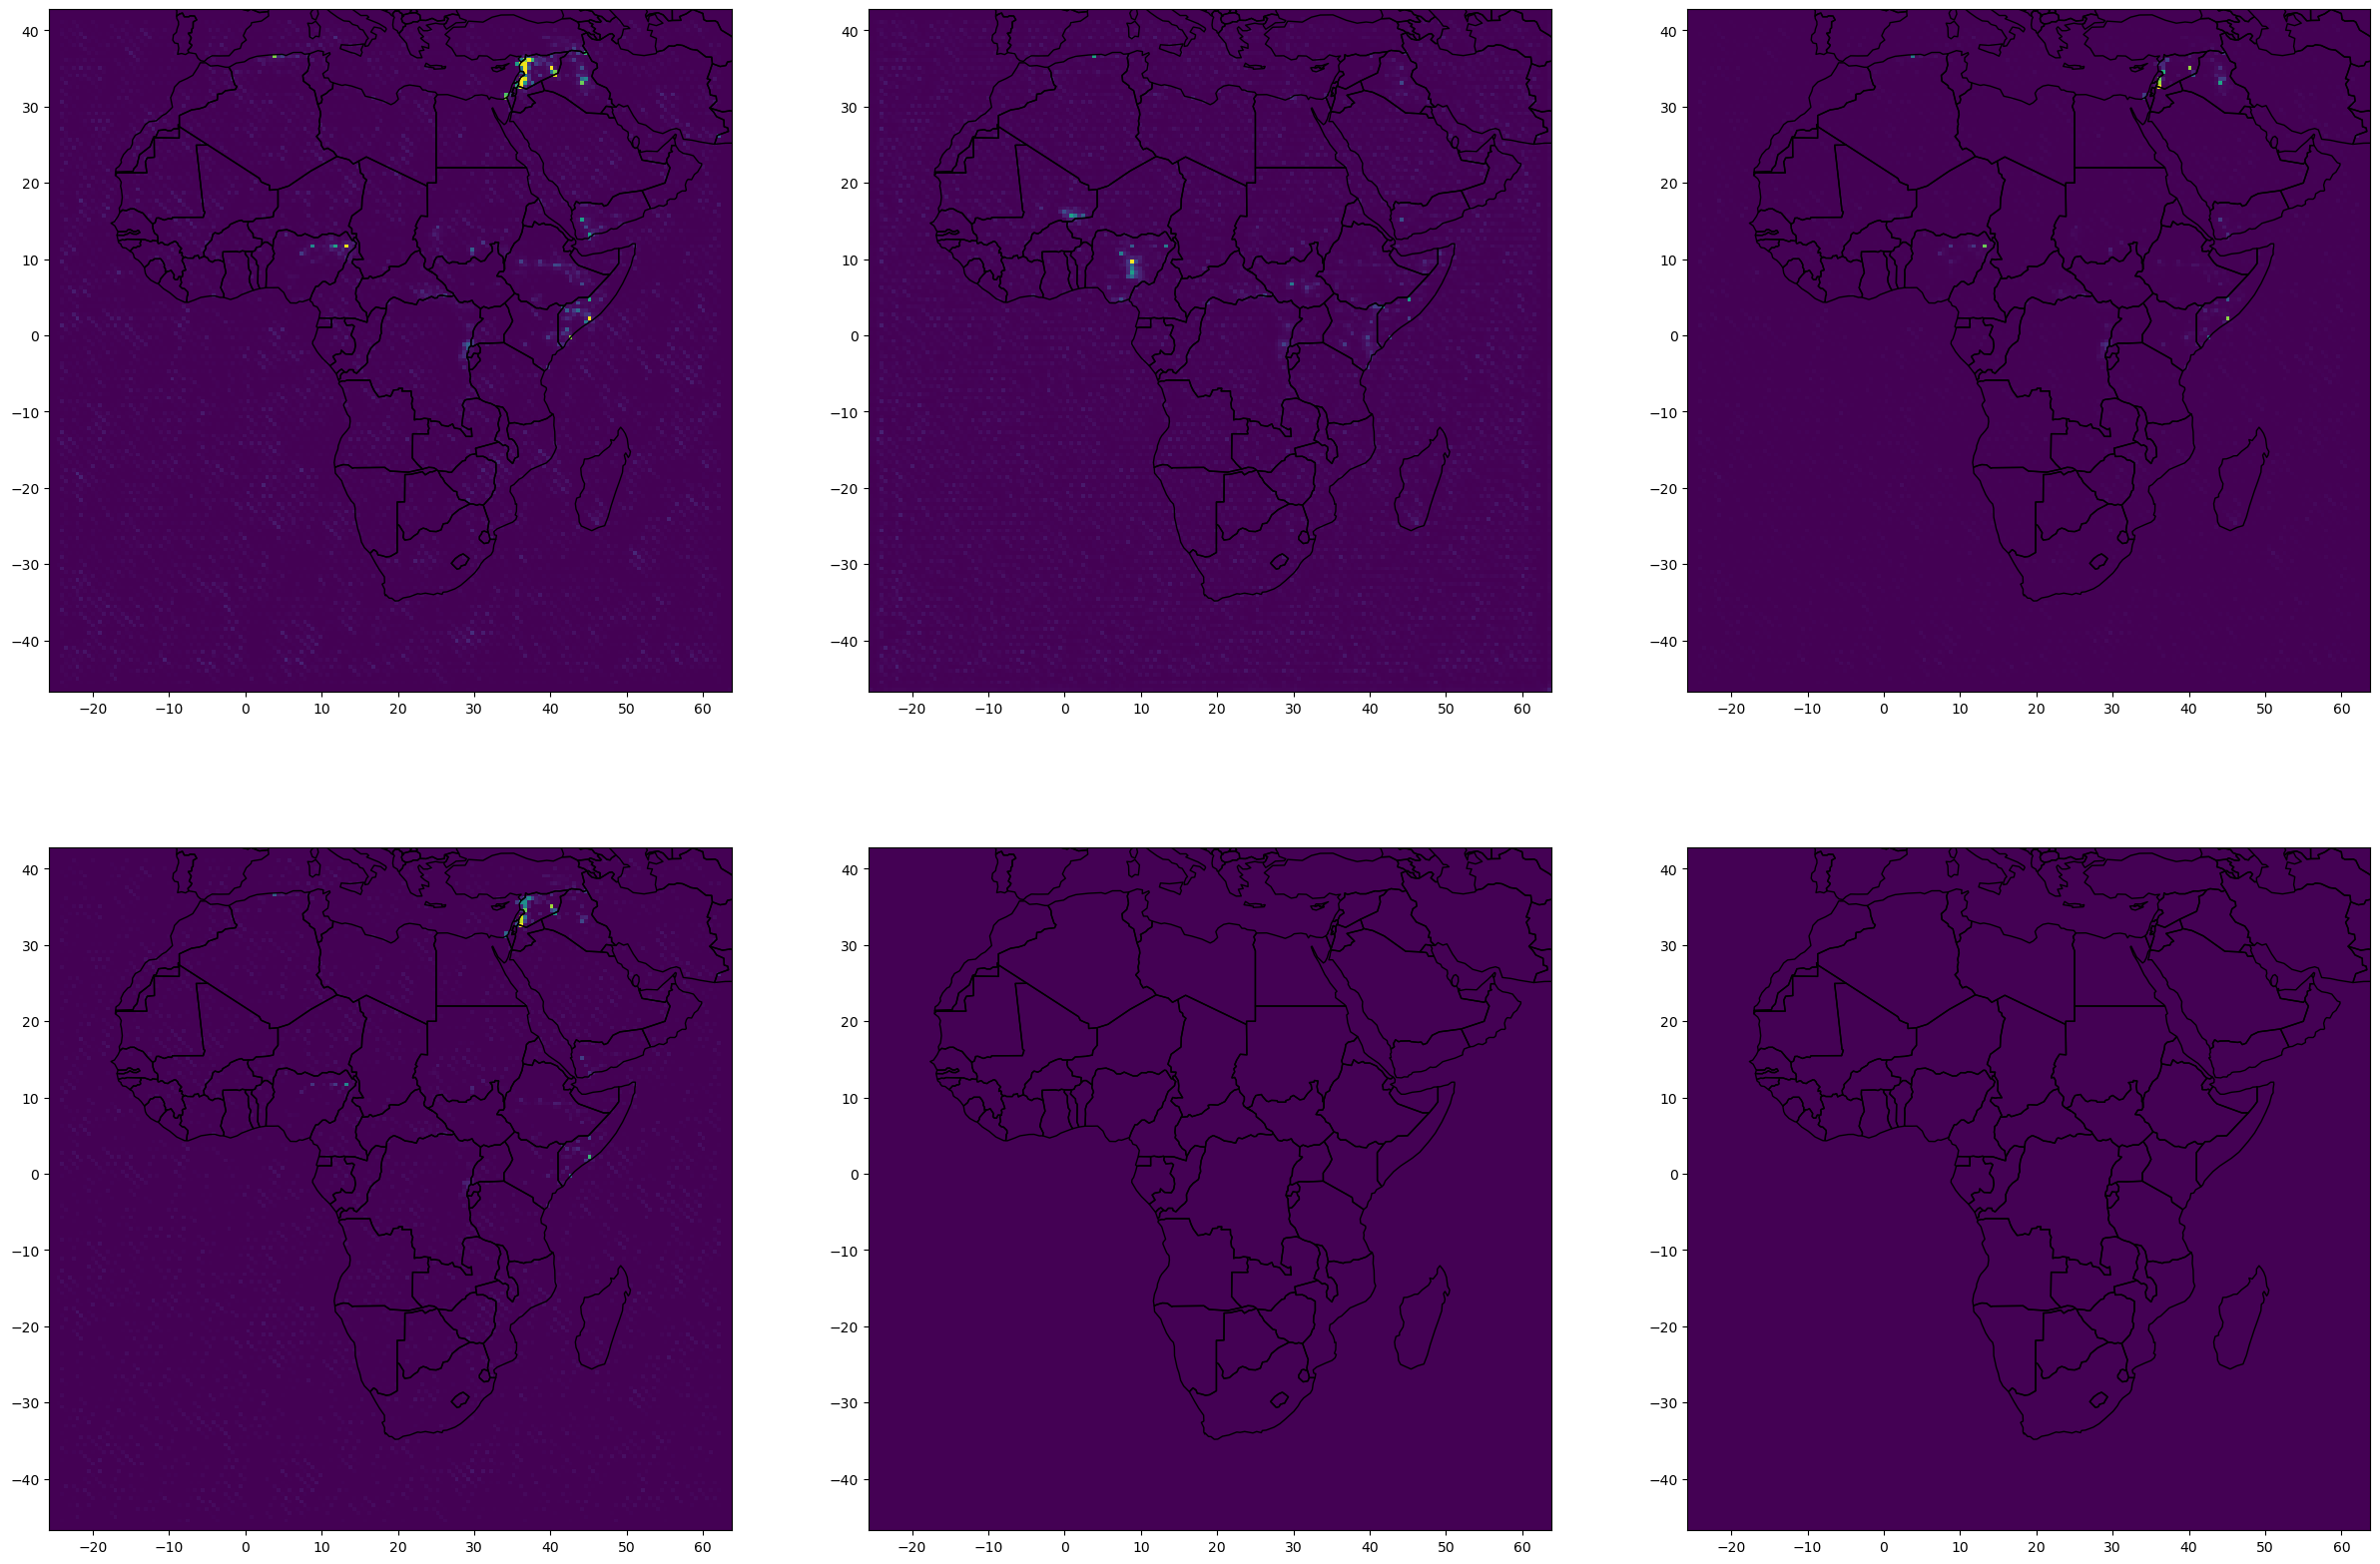

In [18]:
fig, axs = plt.subplots(2,3, )

extent = (views_vol[:,:,:,1].min(), views_vol[:,:,:,1].max(), views_vol[:,:,:,2].min(), views_vol[:,:,:,2].max()) 

fig.set_figheight(20)
fig.set_figwidth(30)

world.plot(ax = axs[0,0], color='none', edgecolor='black')
world.plot(ax = axs[0,1], color='none', edgecolor='black')
world.plot(ax = axs[0,2], color='none', edgecolor='black')
world.plot(ax = axs[1,0], color='none', edgecolor='black')
world.plot(ax = axs[1,1], color='none', edgecolor='black')
world.plot(ax = axs[1,2], color='none', edgecolor='black')

axs[0,0].imshow(mean_class_pred[0,:,:], extent = extent)
axs[0,1].imshow(mean_class_pred[1,:,:], extent = extent)
axs[0,2].imshow(mean_class_pred[2,:,:], extent = extent)
axs[1,0].imshow(mean_pred[0,:,:], extent = extent)
axs[1,1].imshow(mean_pred[1,:,:], extent = extent)
axs[1,2].imshow(mean_pred[2,:,:], extent = extent)

plt.show()

In [12]:
# insert overall ap score.

def plt_trio(test_month, timelaps_dir, posterior_dict, views_vol):

    interpolation = 'none'

    extent = (views_vol[:,:,:,1].min(), views_vol[:,:,:,1].max(), views_vol[:,:,:,2].min(), views_vol[:,:,:,2].max()) 
#    extent = (-100, 80, -100, 80) 


    posterior_list = posterior_dict['posterior_list']
    posterior_list_class = posterior_dict['posterior_list_class']
    out_of_sample_vol = posterior_dict['out_of_sample_vol']

    mean_class_pred = np.array(posterior_list_class[test_month]).mean(axis=0)[0,:,:]
    mean_pred = np.array(posterior_list[test_month]).mean(axis=0)[0,:,:]
    true_obs = out_of_sample_vol[:,test_month,:,:].squeeze()[0,:,:]

    std_pred = np.array(posterior_list[test_month]).std(axis=0)

    # min/max for plotting
    min_true = out_of_sample_vol[:,0,:,:].min()
    max_true = out_of_sample_vol[:,0,:,:].max()
    min_pred = np.array(posterior_list).min()
    max_pred = np.array(posterior_list).max()
    min_pred_class = np.array(posterior_list_class).min()
    max_pres_class = np.array(posterior_list_class).max()

    min_pred_std = np.array(posterior_list).mean(axis=0).std(axis = 0).min()
    max_pred_std = np.array(posterior_list).mean(axis=0).std(axis = 0).max()

    all_abs_error = np.abs(out_of_sample_vol[:,0,:,:].squeeze() - np.array(posterior_list).mean(axis = 0))
    min_error = all_abs_error.min()
    max_error = all_abs_error.max()

    # abs error
    abs_error = np.abs(true_obs - mean_pred)


    # Confucsion
    threshold = 0.2 # there is a good way to do this... You have just forgotten it...

    binary_pred = (mean_class_pred > threshold) * 1 
    binary_true = (true_obs > 0)*1

    TP = ((binary_pred == 1) & (binary_true == 1)).astype('int')
    FP = ((binary_pred == 1) & (binary_true == 0)).astype('int')*2
    FN = ((binary_pred == 0) & (binary_true == 1)).astype('int')*3
    # TN = ((binary_pred == 0) & (binary_true == 0)).astype('int')*4


    confusion_map = TP + FP + FN #+ TN # TN per defualt 0

    # TN gray, TP green, FP blue, FN red
    colors = [ (0.5, 0.5, 0.5), (0, 1, 0), (0, 0, 1), (1, 0, 0)]  # R, G, B
    cmap_name = 'catagorical4'
    cat_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=4)

    # plot
    #plt.figure(figsize=[30,20])

    fig, axs = plt.subplots(2,3, sharey= True, sharex= True)
    
    fig.set_figheight(20)
    fig.set_figwidth(30)

    plt.subplots_adjust(wspace=-0.01, hspace=-0.2)

    axs[0,0].set_title(f'true, month {test_month}')
    true_obs_masked = np.ma.masked_where((views_vol[-48,:,:,4] == 0), true_obs)
    world.plot(ax = axs[0,0], color='none', edgecolor='black')
    im = axs[0,0].imshow(true_obs_masked, cmap = 'rainbow', vmin= min_true, vmax=max_true, aspect= 'equal', interpolation = interpolation, extent = extent)
    plt.colorbar(im, ax = axs[0,0], shrink = 0.6, label = 'observed magnitude y, i.e. log(best)')

    axs[0,1].set_title(f'pred, month {test_month}')
    mean_pred_masked = np.ma.masked_where((views_vol[-48,:,:,4] == 0), mean_pred)
    world.plot(ax = axs[0,1],color='none', edgecolor='black', figsize = [25,25])
    im = axs[0,1].imshow(mean_pred_masked, cmap = 'rainbow', vmin= min_pred, vmax=max_pred, aspect= 'equal', interpolation = interpolation, extent = extent)
    plt.colorbar(im, ax = axs[0,1], shrink = 0.6, label = 'predictited magnitude, ŷ ')


    axs[0,2].set_title(f'pred class, month {test_month}')
    mean_class_pred_masked = np.ma.masked_where((views_vol[-48,:,:,4] == 0), mean_class_pred)
    world.plot(ax = axs[0,2],color='none', edgecolor='black', figsize = [25,25])
    im = axs[0,2].imshow(mean_class_pred_masked, cmap = 'rainbow', vmin= min_pred_class, vmax=max_pres_class, aspect= 'equal', interpolation = interpolation, extent = extent)
    plt.colorbar(im, ax = axs[0,2], shrink = 0.6, label = 'predictited probability, ỹ')


    axs[1,0].set_title(f'absolute error, month {test_month}')
    abs_error_masked = np.ma.masked_where((views_vol[-48,:,:,4] == 0), abs_error)
    world.plot(ax = axs[1,0],color='none', edgecolor='black', figsize = [25,25])
    im = axs[1,0].imshow(abs_error_masked, cmap = 'rainbow', vmin=min_error, vmax=max_error, aspect= 'equal', interpolation = interpolation, extent = extent) # min and max are not constant here!
    plt.colorbar(im, ax = axs[1,0], shrink = 0.6, label = 'absolute error, |y-ŷ|')


    axs[1,1].set_title(f'pred std, month {test_month}')  # wonrg title
    std_pred_masked = np.ma.masked_where((views_vol[-48,:,:,4] == 0), std_pred)
    world.plot(ax = axs[1,1],color='none', edgecolor='black', figsize = [25,25])
    im = axs[1,1].imshow(std_pred_masked, cmap = 'rainbow', vmin=min_pred_std, vmax=max_pred_std, aspect= 'equal', interpolation = interpolation, extent = extent)
    plt.colorbar(im, ax = axs[1,1], shrink = 0.6,  label = 'ensemble std (predicted magnitude, ŷ)')


    axs[1,2].set_title(f'confusion_map (T=0.2)pred std, month {test_month}')  # wonrg title
    confusion_map_masked = np.ma.masked_where((views_vol[-48,:,:,4] == 0), confusion_map)
    world.plot(ax = axs[1,2],color='none', edgecolor='black', figsize = [25,25])
    im = axs[1,2].imshow(confusion_map_masked, cmap = cat_cmap, vmin=0, vmax=3, aspect= 'equal', interpolation = interpolation, extent = extent)
    cbar = plt.colorbar(im, ax = axs[1,2], ticks = np.linspace(0.4,2.6,4), shrink = 0.6)
    cbar.set_ticklabels(['TN', 'TP', 'FP', 'FN'])

    #plt.subplots_adjust(hspace = -0.1, wspace = 0.1)

    fig_title = f'trio_{str(test_month).zfill(2)}'
    #plt.savefig(timelaps_dir + '/' + fig_title + '.JPG', bbox_inches="tight")
    
    plt.show()
    
    #plt.cla() # idk if this is also needed..
    #plt.clf() # idk if this is also needed..
    plt.close(fig) # so they do not display or take up mem
    #gc.collect()

In [13]:
plt_trio(0, timelaps_dir, posterior_dict, views_vol)

: 

: 

In [4]:
for i in range(48):
    plt_trio(i, timelaps_dir, posterior_dict, views_vol)